In [56]:
"""Ranks candidates by the Schulze method.
For more information read http://en.wikipedia.org/wiki/Schulze_method.
"""

__author__ = "Michael G. Parker"
__contact__ = "http://omgitsmgp.com/"


from collections import defaultdict


def _add_remaining_ranks(d, candidate_name, remaining_ranks, weight):
    for remaining_rank in remaining_ranks:
        for other_candidate_name in remaining_rank:
            d[candidate_name, other_candidate_name] += weight


def _add_ranks_to_d(d, ranks, weight):
    for i, rank in enumerate(ranks):
        remaining_ranks = ranks[i+1:]
        for candidate_name in rank:
            _add_remaining_ranks(d, candidate_name, remaining_ranks, weight)


def _compute_d(weighted_ranks):
    """Computes the d array in the Schulze method.
    d[V,W] is the number of voters who prefer candidate V over W.
    """
    d = defaultdict(int)
    for ranks, weight in weighted_ranks:
        _add_ranks_to_d(d, ranks, weight)
    return d


def _compute_p(d, candidate_names):
    """Computes the p array in the Schulze method.
    p[V,W] is the strength of the strongest path from candidate V to W.
    """
    p = {}
    for candidate_name1 in candidate_names:
        for candidate_name2 in candidate_names:
            if candidate_name1 != candidate_name2:
                strength = d.get((candidate_name1, candidate_name2), 0)
                if strength > d.get((candidate_name2, candidate_name1), 0):
                    p[candidate_name1, candidate_name2] = strength

    for candidate_name1 in candidate_names:
        for candidate_name2 in candidate_names:
            if candidate_name1 != candidate_name2:
                for candidate_name3 in candidate_names:
                    if (candidate_name1 != candidate_name3) and (candidate_name2 != candidate_name3):
                        curr_value = p.get((candidate_name2, candidate_name3), 0)
                        new_value = min(
                                p.get((candidate_name2, candidate_name1), 0),
                                p.get((candidate_name1, candidate_name3), 0))
                        if new_value > curr_value:
                            p[candidate_name2, candidate_name3] = new_value

    return p


def _rank_p(candidate_names, p):
    """Ranks the candidates by p."""
    candidate_wins = defaultdict(list)

    for candidate_name1 in candidate_names:
        num_wins = 0

        # Compute the number of wins this candidate has over all other candidates.
        for candidate_name2 in candidate_names:
            if candidate_name1 == candidate_name2:
                continue
            candidate1_score = p.get((candidate_name1, candidate_name2), 0)
            candidate2_score = p.get((candidate_name2, candidate_name1), 0)
            if candidate1_score > candidate2_score:
                num_wins += 1

        candidate_wins[num_wins].append(candidate_name1)

    sorted_wins = sorted(candidate_wins.keys(), reverse=True)
    return [candidate_wins[num_wins] for num_wins in sorted_wins]


def compute_ranks(candidate_names, weighted_ranks):
    """Returns the candidates ranked by the Schulze method.
    See http://en.wikipedia.org/wiki/Schulze_method for details.
    Parameter candidate_names is a sequence containing all the candidate names.
    Parameter weighted_ranks is a sequence of (ranks, weight) pairs.
    The first element, ranks, is a ranking of the candidates. It is an array of arrays so that we
    can express ties. For example, [[a, b], [c], [d, e]] represents a = b > c > d = e.
    The second element, weight, is typically the number of voters that chose this ranking.
    """
    d = _compute_d(weighted_ranks)
    p = _compute_p(d, candidate_names)
    return _rank_p(candidate_names, p)

In [89]:
import numpy as np
candidate_names = range(1,12)
# ranks = [candidate_names]
ranks = [
[7,	6,	10,	8,	1,	4,	11,	9,	5,	3,	2],
[11,9,	7,	2,	10,	8,	6,	5,	3,	1,	4],
[6,	8,	10,	4,	7,	11,	2,	9,	3,	5,	1],
[6,	8,	10,	7,	4,	11,	9,	1,	2,	3,	5],
[6,	8,	10,	7,	11,	4,	9,	2,	3,	1,	5],
[6,	7,	10,	11,	8,	4,	9,	1,	3,	2,	5]
]
weighted_ranks = [([[r] for r in rank], 1) for rank in ranks]
compute_ranks(candidate_names, weighted_ranks)

[[6], [7, 8, 10], [4, 11], [9], [2], [1, 3], [5]]

In [75]:
weighted_ranks

[([4, 2, 3, 6, 1, 11, 10, 7, 5, 9, 8], 1)]

In [20]:
from scipy.stats import spearmanr
from utils.data import *
from utils.analysis import evaluate_prediction_owa
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from copy import deepcopy
max_owa_clip = 3.5

In [123]:
seasonalities = ['Hourly','Daily','Weekly'] # ["Monthly","Yearly","Quarterly"]
seasonality = seasonalities[0]

X_train_df, y_train_df, X_test_df, y_test_df = m4_parser(seasonality, 'data', 'forecasts',
                                                                load_existing_dataframes=True)

for seasonality in  seasonalities[1:]:
    _X_train_df, _y_train_df, _X_test_df, _y_test_df = m4_parser(seasonality, 'data', 'forecasts',
                                                                load_existing_dataframes=True)
    X_train_df = pd.concat((X_train_df,_X_train_df))
    y_train_df = pd.concat((y_train_df,_y_train_df))
    X_test_df = pd.concat((X_test_df,_X_test_df))
    y_test_df = pd.concat((y_test_df,_y_test_df))

base_errors = y_test_df.copy()
base_errors = base_errors.drop_duplicates('unique_id').set_index('unique_id')
base_errors = base_errors.filter(regex='^OWA_', axis=1)
base_errors.columns = base_errors.columns.str.lstrip('OWA_')
base_errors.columns = base_errors.columns.str.lstrip('mdl_')
plot_base_errors = deepcopy(base_errors)

plot_base_errors.rename(columns={'ESRNN': 'ES-RNN'},
                        inplace=True)

for mdl, avg_owa in zip(base_errors.columns, base_errors.mean()):
    str_result = mdl + " average : " + str(avg_owa)
    print(str_result)

ensemble_owas_ = pd.DataFrame()
for seasonality in  seasonalities:
    ensemble_owas = None
    for file in glob.glob(f"results/*{seasonality[0]}.npy"):
        model_name = file.rsplit(f"_{seasonality[0]}.npy")[0].split("/")[1]    
        try:
            owas = np.load(file)
        except ValueError:
            owas = None
            print(file)
        if owas is not None:
            if ensemble_owas is None:
                ensemble_owas = pd.DataFrame(owas,columns=[model_name])
            else:
                ensemble_owas[model_name] = owas            
        else:
            print(file)    
    ensemble_owas_ = pd.concat((ensemble_owas_, ensemble_owas))
        

ensemble_owas_.rename(columns={'Model Averaging': 'AVG',
                               'Neural Averaging 2': 'FFORMA-N',
                               'Neural Stacking': 'NN-STACK',
                               'OLD_FFORMS':'FFORMS-R',
                               'FFORMS':'FFORMS-G',
                                },
                        inplace=True)
plot_ensemble_errors = deepcopy(ensemble_owas_)
plot_ensemble_errors = plot_ensemble_errors.drop(columns=["Neural Averaging", 
                                                          "Neural Stacking 2",
                                                          "nbeats"],errors='ignore')
plot_ensemble_errors.describe()

ARIMA average : 0.9996073751920922
Comb average : 1.0258061705641983
Damped average : 1.0063590552061679
ESRNN average : 0.9827885788814025
Theta average : 0.9964581368297244


,FFORMA,FFORMS-G,AVG,FFORMA-N,NN-STACK,FFORMS-R
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.917094,0.920263,0.964534,0.914740,0.960158,0.917495
std,1.226420,1.250609,1.239415,1.225990,1.680363,1.220629
min,0.013589,0.016506,0.025388,0.015617,0.027531,0.037898
25%,0.404952,0.405402,0.381146,0.401684,0.392074,0.398797
50%,0.671758,0.673569,0.663707,0.667684,0.647007,0.666144
75%,1.093473,1.091259,1.101415,1.090782,1.079395,1.082034
max,25.903416,28.923804,24.710538,26.025149,79.151492,25.061488


In [1]:
from utils.data import m4_ts_parser, seas_dict

In [2]:
seas_dict

{'Hourly': {'seasonality': 24,
  'input_size': 24,
  'output_size': 48,
  'freq': 'H',
  'tail_inputs': 0},
 'Daily': {'seasonality': 7,
  'input_size': 7,
  'output_size': 14,
  'freq': 'D',
  'tail_inputs': 0},
 'Weekly': {'seasonality': 52,
  'input_size': 52,
  'output_size': 13,
  'freq': 'W',
  'tail_inputs': 0},
 'Monthly': {'seasonality': 12,
  'input_size': 12,
  'output_size': 18,
  'freq': 'M',
  'tail_inputs': 0},
 'Quarterly': {'seasonality': 4,
  'input_size': 4,
  'output_size': 8,
  'freq': 'Q',
  'tail_inputs': 0},
 'Yearly': {'seasonality': 1,
  'input_size': 4,
  'output_size': 6,
  'freq': 'D',
  'tail_inputs': 0}}

In [1]:
from utils.data import *
seasonality = 'Weekly'
_, y_train_df, X_test_df, y_test_df = m4_parser(seasonality, 'data', 'forecasts', load_existing_dataframes=True)
_, y_train_df_ts, _, y_test_df_ts, ts_pred_data = m4_ts_parser(seasonality, "data")
combination_type = 'Deep FFORMA'

In [2]:
(
#y_train_df_ts.groupby("unique_id").count().quantile(0.00),
# y_train_df_ts.groupby("unique_id").count().quantile(0.01),
y_train_df_ts.groupby("unique_id").count().quantile(0.05),
# y_train_df_ts.groupby("unique_id").count().quantile(0.15),
# y_train_df_ts.groupby("unique_id").count().quantile(0.50),
# y_train_df_ts.groupby("unique_id").count().quantile(0.85),
y_train_df_ts.groupby("unique_id").count().quantile(0.95),
# y_train_df_ts.groupby("unique_id").count().quantile(0.99),
# y_train_df_ts.groupby("unique_id").count().quantile(1.00)
)

(ds    80.0
 y     80.0
 Name: 0.05, dtype: float64,
 ds    2283.0
 y     2283.0
 Name: 0.95, dtype: float64)

In [1]:
from fforma import FFORMA
from fforma.optimization import *
from neuralaverage.mlp import *
from deepfforma.mlp import DeepFFORMA
from stacking.mlp import *
from utils.data import *
import pandas as pd
import numpy as np
from utils.analysis import evaluate_prediction_owa
from configs.configs import FFORMA_CONFIGS, FEATURE_CONFIGS, NEURALSTACK_CONFIGS, NEURALAVERAGE_CONFIGS, DEEPFFORMA_CONFIGS
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import locally_linear_embedding
from sklearn.preprocessing import StandardScaler, RobustScaler
from lightgbm import LGBMRegressor
import lightgbm as lgb
from nbeats_keras.model import NBeatsNet
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanAbsolutePercentageError
import keras.backend as K
import seaborn as sns

In [2]:
for seasonality in ['Hourly','Daily','Weekly','Monthly','Quarterly','Yearly'][4:5]:
    # seasonality = 'Daily'
    print(f"Loading Data {seasonality}")

    _, y_train_df, X_test_df, y_test_df = m4_parser(seasonality, 'data', 'forecasts', load_existing_dataframes=True)
    _, _, _, _, ts_pred_data = m4_ts_parser(seasonality, "data")
            
    for combination_type in ['nbeats',
                                'FFORMA',
                                'FFORMS',
                                'Model Averaging',
                                'Neural Averaging 2',
                                'Neural Stacking',
                                'Deep FFORMA'][-1:]:
        print(f"Starting {seasonality} {combination_type}")

Loading Data Quarterly
Starting Quarterly Deep FFORMA


In [3]:
df_info=X_test_df
df_pred_data=y_test_df
y_train_df=y_train_df
ts_pred_data=ts_pred_data
seasonality=seasonality

In [4]:
from utils.data import *
kfoldings = make_kfolds(df_info, df_pred_data, 10, seed=0)
train_set, test_set = train_test_split(kfoldings, 0)

In [5]:
train_errors = train_set.copy()
train_errors = train_errors.drop_duplicates('unique_id').set_index('unique_id')
train_errors = train_errors.filter(regex='^OWA_',axis=1)
train_errors.columns = train_errors.columns.str.lstrip('OWA_')

In [6]:
train_feats = train_set.copy()
train_feats = train_feats.set_index('unique_id')
train_feats = train_feats.filter(regex='^mf_', axis=1)
test_feats = test_set.copy()
test_feats = test_feats.set_index('unique_id')
test_feats = test_feats.filter(regex='^mf_', axis=1)

In [7]:
base_model_names = []
for base_model in train_set.columns[train_set.columns.str.startswith('mdl_')].tolist():
    if base_model != 'mdl_naive2':
        base_model_names.append(base_model)

In [8]:
y_hat_base_models_train = train_set[['unique_id', 'ds'] + base_model_names].set_index(['unique_id', 'ds'])
y_hat_base_models_test = test_set[['unique_id','ds'] + base_model_names].set_index(['unique_id','ds'])

In [9]:
from pyexpat import model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd

def fforma_loss(y_OWA, y_wm):
    return tf.reduce_sum(y_wm*y_OWA, axis=-1)

def Conv_1D_Block(x, model_width, kernel):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, padding='same', kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def VGG_11(length, num_channel, num_filters, dropout_rate, min_length):
    inputs = tf.keras.Input((length, num_channel))  # The input tensor    
    # normal = tf.keras.layers.UnitNormalization(axis=1)(inputs)
    normal = tf.keras.layers.LayerNormalization()(inputs)

    # Block 1
    # x = Conv_1D_Block(normal, num_filters * (2 ** 0), 3)
    # if min_length >= 10:
    #     x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)
    # # else:
    # #     x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding="valid")(x)
    # # xa = tf.keras.layers.GlobalMaxPooling1D()(x)

    # # Block 2
    # x = Conv_1D_Block(x, num_filters * (2 ** 1), 3)
    # if min_length >= 16:
    #     x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)
    # # else:
    # #     x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding="valid")(x)
    # # xb = tf.keras.layers.GlobalMaxPooling1D()(x)

    # # Block 3
    # x = Conv_1D_Block(x, num_filters * (2 ** 2), 3)
    # x = Conv_1D_Block(x, num_filters * (2 ** 2), 3)
    # if min_length >= 24:
    #     x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)
    # # else:
    # #     x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding="valid")(x)
    # # xc = tf.keras.layers.GlobalMaxPooling1D()(x)

    # # Block 4
    # x = Conv_1D_Block(x, num_filters * (2 ** 3), 3)
    # x = Conv_1D_Block(x, num_filters * (2 ** 3), 3)
    # if min_length >= 32:
    #     x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)
    # # else:
    # #     x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1, padding="valid")(x)
    # # xd = tf.keras.layers.GlobalMaxPooling1D()(x)

    # # Block 5
    # x = Conv_1D_Block(x, num_filters * (2 ** 3), 3)
    # x = Conv_1D_Block(x, num_filters * (2 ** 3), 3)
    # x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)
    
    # x = tf.keras.layers.GlobalMaxPooling1D()(x) #Global Averaging replaces Flatten
    # xe= x    

    # x = tf.keras.layers.Concatenate(axis=1)([xa,xb,xc,xd,xe])

    # Create model.    
    return inputs, normal

def is_test(x, y):
    return x % 10 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x,y: y

class DeepFFORMA():
    def __init__(self, mc, n_features, n_models):
        self.mc = mc
        min_length  = self.mc['model_parameters']['min_length']
        vgg_filters = self.mc['model_parameters']['vgg_filters']
        dropout_rate = self.mc['model_parameters']['dropout_rate']
        self.batch_size = self.mc['train_parameters']['batch_size']

        layer_units = [(vgg_filters * (2 ** 3))*4,(vgg_filters * (2 ** 3))*4]

        inputs, outputs = VGG_11(None, 1, vgg_filters, dropout_rate, min_length)        
        
        self.features = tf.keras.Model(inputs, outputs)        
        
        for _i in range(len(layer_units)):
            outputs = tf.keras.layers.Dense(layer_units[_i],activation='relu')(outputs)
            if dropout_rate:
                outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
        outputs = tf.keras.layers.Dense(n_features,activation='linear')(outputs)
        # outputs = tf.keras.layers.Dense(n_features,activation='tanh')(outputs)
        outputs = tf.keras.layers.BatchNormalization()(outputs)
        outputs = tf.keras.layers.Dense(n_models, activation='softmax', use_bias=False)(outputs)

        lr = self.mc['train_parameters']['learn_rate']
        self.optimizer = Adam(lr=lr)
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        self.model.compile(loss=fforma_loss, optimizer=self.optimizer)
        
        self.fitted = False

    def fit(self, features, errors):
        train_errors = errors
        ts_pred_data = features
        train_errors_ID = pd.to_numeric(train_errors.index.str[1:], errors='coerce')

        max_length  = self.mc['train_parameters']['max_length']
        if max_length is not None:
            gen_series =  lambda: ((ts_pred_data[uid][-max_length:],trgt) for uid, trgt in zip(train_errors_ID, train_errors.values))
        else:
            gen_series =  lambda: ((ts_pred_data[uid],trgt) for uid, trgt in zip(train_errors_ID, train_errors.values))

        ds_series_validate = tf.data.Dataset.from_generator(
                gen_series,
                output_types=(tf.float32, tf.float32), 
                output_shapes=((None,), (5,)))
        
        ds_series_train = tf.data.Dataset.from_generator(
                gen_series,
                output_types=(tf.float32, tf.float32), 
                output_shapes=((None,), (5,)))
        

        validate_dataset = ds_series_validate.enumerate() \
                            .filter(is_test) \
                            .map(recover) \
                            .padded_batch(self.batch_size)

        train_dataset    = ds_series_train.enumerate() \
                            .filter(is_train) \
                            .map(recover) \
                            .padded_batch(self.batch_size)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=self.mc['train_parameters']['stop_grow_count'],
                                              restore_best_weights=True)

        epochs=self.mc['train_parameters']['epochs']

        self.model.fit(train_dataset,
                       epochs=epochs,
                       verbose=1,
                       callbacks=[es],
                       validation_data=validate_dataset,
                       validation_freq=1,                       
                       use_multiprocessing=True,
                       workers=8,
                       )
        self.fitted = True

    def predict(self, features, y_hat_df):
        # assert self.fitted, 'Model not yet fitted'
        test_set_ID = pd.to_numeric(y_hat_df.reset_index().unique_id.str[1:], errors='coerce')
        uids = np.unique(test_set_ID)
        gen_series =  lambda: (features[uid] for uid in uids)
        ds_series_test = tf.data.Dataset.from_generator(
                gen_series,
                output_types=(tf.float32), 
                output_shapes=((None,)))
        test_dataset = ds_series_test.padded_batch(self.batch_size)
        predicted_weights = self.model.predict(test_dataset)
        weights_all = dict((k,v) for k,v in zip(uids, predicted_weights))
        # print(weights_all)
        predicted_weights = np.concatenate([[weights_all[uid]] for uid in test_set_ID])
        print(predicted_weights)
        fforma_preds = predicted_weights * y_hat_df
        fforma_preds = fforma_preds.sum(axis=1)
        fforma_preds.name = 'navg_prediction'
        preds = pd.concat([y_hat_df, fforma_preds], axis=1)
        return preds




In [10]:
deepforma = DeepFFORMA(DEEPFFORMA_CONFIGS[seasonality],
                       train_feats.shape[1],
                       train_errors.shape[1]
                       )

2022-08-04 14:53:14.510661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 14:53:15.119508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 216 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:04:00.0, compute capability: 7.5
2022-08-04 14:53:15.131497: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 216.75M (227278848 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [11]:
train_errors_ID = pd.to_numeric(train_errors.index.str[1:], errors='coerce')

max_length  = 16
if max_length is not None:
    gen_series =  lambda: ((ts_pred_data[uid][-max_length:],trgt) for uid, trgt in zip(train_errors_ID, train_errors.values))
else:
    gen_series =  lambda: ((ts_pred_data[uid],trgt) for uid, trgt in zip(train_errors_ID, train_errors.values))

ds_series_validate = tf.data.Dataset.from_generator(
        gen_series,
        output_types=(tf.float32, tf.float32), 
        output_shapes=((None,), (5,)))

ds_series_train = tf.data.Dataset.from_generator(
        gen_series,
        output_types=(tf.float32, tf.float32), 
        output_shapes=((None,), (5,)))


validate_dataset = ds_series_validate.enumerate() \
                    .filter(is_test) \
                    .map(recover) \
                    .padded_batch(2)

train_dataset    = ds_series_train.enumerate() \
                    .filter(is_train) \
                    .map(recover) \
                    .padded_batch(2)

In [12]:
y_hat_df = y_hat_base_models_test
test_set_ID = pd.to_numeric(y_hat_df.reset_index().unique_id.str[1:], errors='coerce')
uids = np.unique(test_set_ID)
gen_series =  lambda: (ts_pred_data[uid][-267:] for uid in uids)
ds_series_test = tf.data.Dataset.from_generator(
        gen_series,
        output_types=(tf.float32), 
        output_shapes=((None,)))
test_dataset = ds_series_test.padded_batch(2)

In [13]:
it = test_dataset.__iter__()
# for i in range(10):
#     print(it.__next__())
data = it.__next__()

In [14]:
data

<tf.Tensor: shape=(2, 59), dtype=float32, numpy=
array([[1835. , 2322. , 3059. , 1883. , 1896. , 2060. , 2764. , 1743. ,
        1561. , 1934. , 2446. , 1609. , 1236. , 1724. , 2040. , 1409. ,
        1282. , 1637. , 2159. , 1520. , 1279. , 1718. , 2283. , 1515. ,
        1382. , 1804. , 2393. , 1546. , 1405. , 1659. , 2150. , 1479. ,
        1381. , 1623. , 1883. , 1320. ,  978. , 1211. , 1380. ,  916. ,
         715. , 1119. , 1383. ,  933. ,  673. ,  968. , 1182. ,  964. ,
         851. , 1068. , 1290. ,  864. ,  876. , 1068. , 1422. ,  968. ,
         843. , 1241. , 1340. ],
       [ 926.9,  953.5,  945.1,  939.7,  974.1,  989.6,  999.2, 1001.9,
        1045.6, 1053.8, 1065.5, 1103.3, 1102.1, 1117.6, 1116.8, 1150.6,
        1158.9, 1159.9, 1166. , 1174.6, 1204.8, 1226.4, 1228.2, 1285.4,
        1304.3, 1313.4, 1335. , 1366.4, 1365.4, 1382. , 1397.4, 1422.8,
        1460.5, 1444.8, 1455.3, 1486.8, 1452. , 1442.2, 1458.1, 1462.7,
        1457.3, 1509.4, 1526.2, 1517.8, 1509. , 1535.2

<AxesSubplot:>

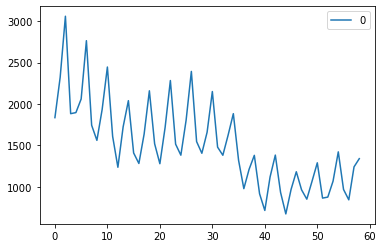

In [15]:
pd.DataFrame(data[0]).plot()

In [16]:
class SumOne(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return w / tf.reduce_sum(w)
    
    @classmethod
    def init(cls, shape, dtype):
        w = tf.random.normal(shape, dtype=dtype)
        w = w / tf.reduce_sum(w)
        return w

class SumZero(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return w - tf.reduce_mean(w)

    @classmethod
    def init(cls, shape, dtype):
        w = tf.random.normal(shape, dtype=dtype)
        w = w - tf.reduce_mean(w)
        return w

In [19]:
inputs = tf.keras.Input((None,1))
# xd = tf.keras.layers.UnitNormalization(axis=1)(inputs)
xd = tf.keras.layers.LayerNormalization(epsilon=1e-8,center=False, scale=False)(inputs)

# xs = tf.keras.layers.Cropping1D(cropping=(2, 0))(xs)
# xs = tf.keras.layers.Subtract()([inputs,x])
# xt = tf.keras.layers.SimpleRNN(1,return_sequences=True)(x)

# xt = tf.keras.layers.AveragePooling1D(pool_size=4, strides=1, padding="same")(xd)
# xt = tf.keras.layers.Conv1D(2, 5,
#                             padding='valid', 
#                             kernel_initializer=SumOne.init,
#                             kernel_constraint=SumOne,
#                             use_bias=False)(inputs)
# xt = tf.keras.layers.UnitNormalization(axis=1)(xt)
# xt = tf.keras.layers.ZeroPadding1D(padding=(2,2))(xt)

# xs = tf.keras.layers.Conv1D(2, 3,
#                             padding='valid',
#                             kernel_initializer=SumZero.init,
#                             kernel_constraint=SumZero,
#                             use_bias=False)(inputs)
# xs = tf.keras.layers.UnitNormalization(axis=1)(xs)
# xs = tf.keras.layers.ZeroPadding1D(padding=(1,1))(xs)

x = tf.keras.layers.Concatenate(axis=2)([xd])
m  = tf.keras.Model(inputs, x)

In [20]:
res = m(data)

In [21]:
np.mean(res, axis=1)

array([[0.],
       [0.]], dtype=float32)

<AxesSubplot:>

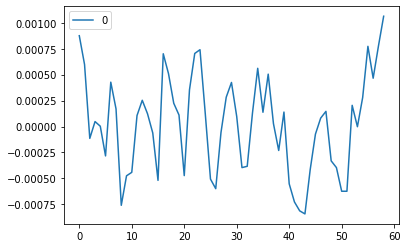

In [62]:
pd.DataFrame(res[0]).plot()

In [46]:
deepforma.fit(ts_pred_data, train_errors)
deepforma_preds = deepforma.predict(ts_pred_data, y_hat_base_models_test)
# NAVG SCORE
test_deepforma_df = test_set.copy()
test_deepforma_df['y_hat'] = deepforma_preds['navg_prediction'].values
predictions_df = test_deepforma_df[['unique_id', 'y_hat', 'ds']]
combination_owa, _, _ = evaluate_prediction_owa(predictions_df=predictions_df,
                                                y_train_df=y_train_df,
                                                y_test_df=test_deepforma_df,
                                                naive2_seasonality=seas_dict[seasonality]['seasonality'],
                                                return_averages=False)
test_df = test_deepforma_df

2022-07-28 22:11:05.006803: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-28 22:11:05.027485: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 763.52MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-28 22:11:05.048746: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-07-28 22:11:05.070918: W tensorflow/core/common_runtime/bfc_allocator.cc:275] All

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
